# QAOA for Two-Color Multi Car Paint Shop Problem
The goal of [the multi-car paint shop problem](https://arxiv.org/pdf/2109.07876) is to reduce the number of color switches between cars in a paint shop line during the manufacturing process, which is recognized as an NP-hard problem.

Let's consider two-color scenario in this tutorial. 

## Expressing the problem using a mathematical model

Given a set of cars $ X = \{x_1, x_2, \dots, x_n\} $ that need to be painted in one of two colors, denoted as $ x_i=0 $ and $ x_i=1 $,  for each $ i = 1, \dots n$. The objective is to minimize the number of color switches (i.e., changes from $ 0 $ to $ 1 $ or from $ 1 $ to $ 0 $) between consecutive cars in the sequence.


The cost of the sequence is the number of times the color switches between consecutive cars, which can be formulated as:

$$
\text{min} \quad - \sum_{i=0}^{N-2} s_i s_{i+1}.
$$

The term, $-s_i \cdot s_{i+1}$, represents consecutive cars and indicates whether they are going to be painted the same color, either $-1$ or $1$. This term becomes $-1$ when the cars are painted the same color, and $+1$ when they are painted different colors. Summing over all the cars in $X$, the cost function is minimized. By converting the spin variables to binary variables, the mathematical expression transforms into the following: 

$$
\text{min} \quad -\sum_{i=0}^{N-2} (x_i - 0.5) \cdot (x_{i+1} - 0.5).
$$

In the Two-Color Multi-Car Paint Shop Problem, the goal is to minimize the number of color switches while meeting specific constraints. In this notebook, we consider the constraint that the scheduled number of cars in each of the two colors per model (the total number of models is $M$) must be met.

$$
 V_{i,m} \cdot x_i = W_m \quad ,\forall m \in \{0, \dots, M-1\}
$$

, where $V_{i,m}$ is a one-hot 2-dimensional matrix representing which model each car $i$ belongs to.

In [1]:
import jijmodeling as jm
import ommx.v1
import qamomile as qm
import numpy as np
import random as rand

## Formulation using JijModeling
Let's first model the problem using JijModeling.

In [2]:
def get_mcps_problem() -> jm.Problem:
  V = jm.Placeholder("V", ndim=2) # sequence of car entry
  W = jm.Placeholder("W", ndim=1) # number of black cars by model
  N = jm.Placeholder("N") # number of cars
  M = jm.Placeholder("M") # number of car models
  x = jm.BinaryVar("x", shape=(N,))
  i = jm.Element("i", belong_to=(0, N-1))
  j = jm.Element("j", belong_to=(0, N))
  m = jm.Element("m", belong_to=(0, M))

  problem = jm.Problem("MCPS") 
  problem += jm.sum([i], -(x[i] - 0.5) * (x[i+1] - 0.5))
  problem += jm.Constraint("n-hot", jm.sum([j], V[j][m] * x[j]) == W[m], forall=m)
  return problem
problem = get_mcps_problem()
problem

In [3]:
car_map = {
    0: "🚗",  # Red car
    1: "🚕",  # Taxi
    2: "🚙",  # SUV
    3: "🚓"   # Police car
}

number_of_models = 4 
number_of_cars = 8
# number of black cars by model
black_per_models = [1, 1, 1, 1]

# Create 8 cars in 4 different kinds of models
cars = [0, 0, 1, 1, 2, 2, 3, 3] 
rand.shuffle(cars)
print(f"The order of car intake: {[car_map[car] for car in cars]}") 

#Create a 2d array of the sequence of car entry
cars_onehot = np.eye(number_of_models)[cars]
print([car_map[i] for i in range(4)])
print(cars_onehot)

The order of car intake: ['🚗', '🚓', '🚕', '🚗', '🚙', '🚓', '🚕', '🚙']
['🚗', '🚕', '🚙', '🚓']
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


## Creating an Instance
An instance is created where actual values are substituted into the constants of the mathematical expressions. Before converting to various algorithms, it is necessary to first create this instance.

In [4]:
data = {"V": cars_onehot, "W":  black_per_models, "N":  number_of_cars, "M": number_of_models}
interpreter = jm.Interpreter(data)
instance = interpreter.eval_problem(problem)

## Generation of QAOA Circuit and Hamiltonian Using Qamomile
Qamomile provides a converter that generates circuits and Hamiltonians for QAOA from the compiled instance. Additionally, it allows setting parameters that arise during the conversion to QUBO.

First, we will generate the Ising Hamiltonian. Once this is done, we can also generate the quantum circuit and Hamiltonian for QAOA. 

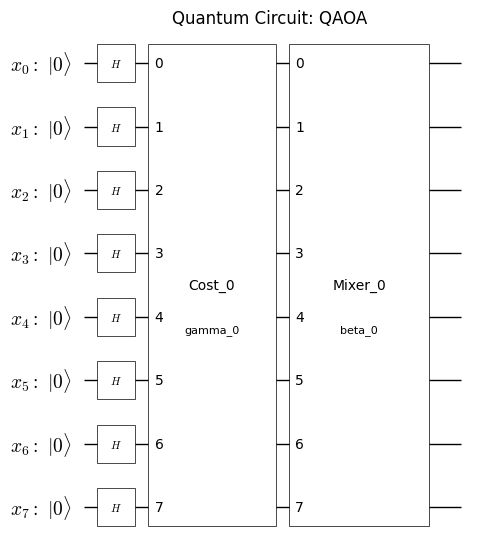

In [5]:
from qamomile.core.converters.qaoa import QAOAConverter
from qamomile.core.circuit.drawer import plot_quantum_circuit

qaoa_converter = QAOAConverter(instance)
# Encode to Ising Hamiltonian
qaoa_converter.ising_encode(multipliers={"n-hot": 3})
# Get the QAOA circuit
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=1)
plot_quantum_circuit(qaoa_circuit) #print it out
# Get the cost Hamiltonian
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

## Converting the Obtained Circuit and Hamiltonian for Qiskit
let's first convert the circuit and Hamiltonian for Qiskit.

In [6]:
import qamomile.qiskit as qm_qk
qk_transpiler = qm_qk.QiskitTranspiler()

# Transpile the QAOA circuit to Qiskit
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_cost)

## Running QAOA
Now that everything is ready, let's run QAOA. Here, we are using Scipy's COBYLA as the optimization algorithm.

In [7]:
import qiskit.primitives as qk_pr
import numpy as np
from scipy.optimize import minimize

cost_history = []
def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data['evs']
    cost_history.append(cost)
    return cost

# Run QAOA optimization
result = minimize(
    cost_estimator,
    np.random.rand(2) * np.pi,
    method="COBYLA",
    options={"maxiter": 100},
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 5.54722023657028
       x: [ 3.534e+00  4.130e+00]
    nfev: 38
   maxcv: 0.0


Let's also take a look at the changes in the cost function

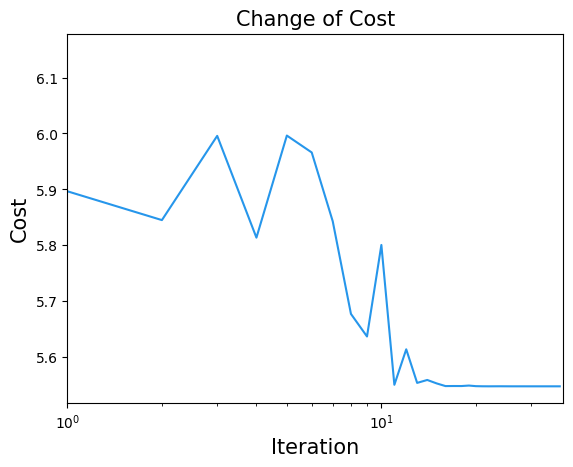

In [8]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

Now we have obtained the QAOA parameters. Let's use them for sampling

In [9]:
# Run Optimized QAOA circuit
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=1000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

## Evaluating the Results

One can determine the optimal solution for the painting order.

In [10]:
paint_map = {
    1: "⚫",  # Black heart 
    0: ""    # Empty string
}

sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

best_sample = sampleset.best_feasible_unrelaxed()
best_values = best_sample.extract_decision_variables("x")

values = [0] * 8
for idx, value in best_values.items():
  values[idx[0]] = 1

print("The order of car intake: ", [car_map[car] for car in cars])
print("Color separation: ", [paint_map[value] for value in values])

The order of car intake:  ['🚗', '🚓', '🚕', '🚗', '🚙', '🚓', '🚕', '🚙']
Color separation:  ['⚫', '⚫', '⚫', '⚫', '⚫', '⚫', '⚫', '⚫']


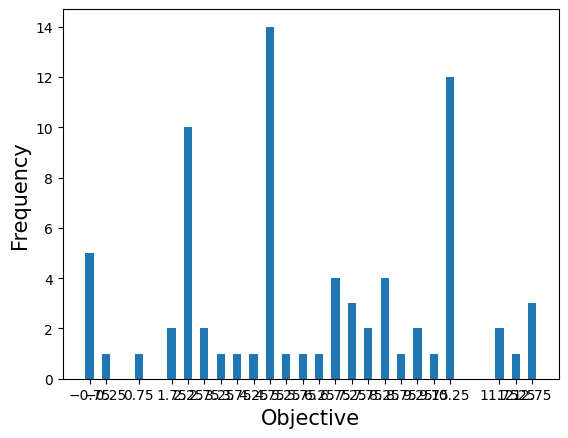

In [11]:
from collections import defaultdict
import matplotlib.pyplot as plt

sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])

# Initialize a dictionary to accumulate occurrences for each energy value
frequencies = defaultdict(int)

# Define the precision to which you want to round the energy values
energy = []
frequencies = {}
for entry in sampleset.raw.objectives.entries:
    e = round(entry.value, ndigits = 3)
    frequencies[e] = len(entry.ids)


plt.bar(frequencies.keys(), frequencies.values(), width=0.25)
plt.xticks(sorted(np.array(list(frequencies.keys()))))
plt.xlabel('Objective', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

## Evaluation using classical algorithms
Comparing the best costs by brute force search.

In [12]:
def eval_mcps_state(cars, black_per_models, state, num_cars, num_models):
  cnt = [0] * num_models
  for i in range(num_cars):
    cnt[cars[i]] += state[i]
  for i in range(num_models):
    if black_per_models[i] != cnt[i]:
      return None
  score = 0
  for i in range(num_cars-1):
    if state[i] != state[i+1]:
      score += 1
  return score

def best_cost_mcps(cars, black_per_models, num_cars, num_models):
  best_score = 1e9
  for i in range(2**num_cars):
    state = [0] * num_cars
    for j in range(num_cars):
      if i & (2**j) != 0:
        state[j] = 1
    score = eval_mcps_state(cars, black_per_models, state, num_cars, num_models)
    if not(score is None):
      best_score = min(best_score, score)
  return best_score

exact_score = best_cost_mcps(cars, black_per_models, number_of_cars, number_of_models)
qaoa_score = eval_mcps_state(cars, black_per_models, values, number_of_cars, number_of_models)
print("exact solution: ", exact_score)
print("solution using QAOA: ", qaoa_score)

exact solution:  2
solution using QAOA:  None
